In [1]:
# Step 1: Install necessary libraries (if not installed)
!pip install yfinance xgboost

# Step 2: Import libraries
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


In [2]:
# Step 3: Fetch AAPL data
ticker = "AAPL"
data = yf.download(ticker, start="2020-09-01", end="2024-06-10")  # Adjust dates if needed

# Step 4: Feature Engineering
data['Return'] = data['Close'].pct_change()  # Daily returns
data['SMA_10'] = data['Close'].rolling(window=10).mean()  # 10-day Simple Moving Average
data['SMA_50'] = data['Close'].rolling(window=50).mean()  # 50-day SMA
data['Volatility'] = data['Return'].rolling(window=10).std()  # Rolling Volatility
data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()  # Exponential Moving Average (EMA)
data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['RSI'] = 100 - (100 / (1 + data['Return'].rolling(window=14).mean() / data['Return'].rolling(window=14).std()))  # RSI
data.dropna(inplace=True)  # Drop NaN values caused by rolling operations

# Target Variable
data['Target'] = data['Close'].shift(-1)  # Next day's price as target
data.dropna(inplace=True)

# Apply log transformation to target
data['Target'] = np.log1p(data['Target'])

# Preview the data
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,Return,SMA_10,SMA_50,Volatility,EMA_10,EMA_50,RSI,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,,
Date,,,,,,,,,,,,,,
2020-11-10,113.401848,115.970001,117.589996,114.129997,115.550003,138023400,-0.003009,113.955,115.6578,0.033723,115.420647,117.964216,-0.609082,4.791567
2020-11-11,116.843895,119.489998,119.629997,116.440002,117.190002,112295000,0.030353,114.784,115.3640,0.030601,116.160529,118.024050,8.341423,4.789240
2020-11-12,116.570099,119.209999,120.529999,118.570000,119.620003,103162300,-0.002343,115.173,115.1202,0.028882,116.714978,118.070558,9.127058,4.789656
2020-11-13,116.619003,119.260002,119.669998,117.870003,119.440002,81581900,0.000419,116.213,115.0878,0.020093,117.177710,118.117203,9.194434,4.798267
2020-11-16,117.635956,120.300003,120.989998,118.150002,118.919998,91183000,0.008720,117.366,115.0746,0.019780,117.745400,118.202803,8.258325,4.790736


In [3]:
# Step 5: Train-Test Split
train_data = data[0:int(len(data) * 0.77)]  # Train on the first 77%
test_data = data[int(len(data) * 0.77):]    # Test on the remaining 23%

# Features and Target
X_train = train_data[['Close', 'SMA_10', 'SMA_50', 'Volatility', 'EMA_10', 'EMA_50', 'RSI']].values
y_train = train_data['Target'].values
X_test = test_data[['Close', 'SMA_10', 'SMA_50', 'Volatility', 'EMA_10', 'EMA_50', 'RSI']].values
y_test = test_data['Target'].values

# Confirm sizes
print(f"Training data size: {X_train.shape}, {y_train.shape}")
print(f"Testing data size: {X_test.shape}, {y_test.shape}")


Training data size: (691, 7), (691,)
Testing data size: (207, 7), (207,)


In [4]:
# Step 6: Scale Features and Target
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Print sample scaled values
print("Scaled X_train sample:", X_train_scaled[0])
print("Scaled y_train sample:", y_train_scaled[0])


Scaled X_train sample: [-1.85443227e+00 -1.96575686e+00 -1.92995106e+00  2.48770928e+00
 -1.90355968e+00 -1.85818925e+00 -1.89926113e-03]
Scaled y_train sample: -1.8212034165326914


In [5]:
# Step 7: Train XGBoost Model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.09,
    'max_depth': 3,
}
evals_result = {}
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled)

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=True
)

# Confirm model training
print("Model training complete.")


[0]	train-rmse:0.91471	eval-rmse:1.47090
[1]	train-rmse:0.83726	eval-rmse:1.34443
[2]	train-rmse:0.76667	eval-rmse:1.22886
[3]	train-rmse:0.70248	eval-rmse:1.12539
[4]	train-rmse:0.64405	eval-rmse:1.02989
[5]	train-rmse:0.59100	eval-rmse:0.93003
[6]	train-rmse:0.54282	eval-rmse:0.85277
[7]	train-rmse:0.49920	eval-rmse:0.78208
[8]	train-rmse:0.45944	eval-rmse:0.71641
[9]	train-rmse:0.42359	eval-rmse:0.65622
[10]	train-rmse:0.39117	eval-rmse:0.60208
[11]	train-rmse:0.36190	eval-rmse:0.55287
[12]	train-rmse:0.33529	eval-rmse:0.50814
[13]	train-rmse:0.31136	eval-rmse:0.46636
[14]	train-rmse:0.28992	eval-rmse:0.42950
[15]	train-rmse:0.27073	eval-rmse:0.39604
[16]	train-rmse:0.25351	eval-rmse:0.36588
[17]	train-rmse:0.23824	eval-rmse:0.33933
[18]	train-rmse:0.22457	eval-rmse:0.31451
[19]	train-rmse:0.21244	eval-rmse:0.29216
[20]	train-rmse:0.20174	eval-rmse:0.27385
[21]	train-rmse:0.19224	eval-rmse:0.25540
[22]	train-rmse:0.18388	eval-rmse:0.23561
[23]	train-rmse:0.17653	eval-rmse:0.22109
[2

In [6]:
# Step 8: Predictions and Metrics
y_pred_train_scaled = bst.predict(dtrain)
y_pred_test_scaled = bst.predict(dtest)

# Inverse transform
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

# Metrics
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"R-squared on Test Data: {r2_test}")
print(f"Mean Absolute Error on Test Data: {mae_test}")
print(f"Mean Absolute Percentage Error on Test Data: {100 * mape_test}%")


R-squared on Test Data: 0.8931779926473156
Mean Absolute Error on Test Data: 0.01214911104623858
Mean Absolute Percentage Error on Test Data: 0.23345040725946453%


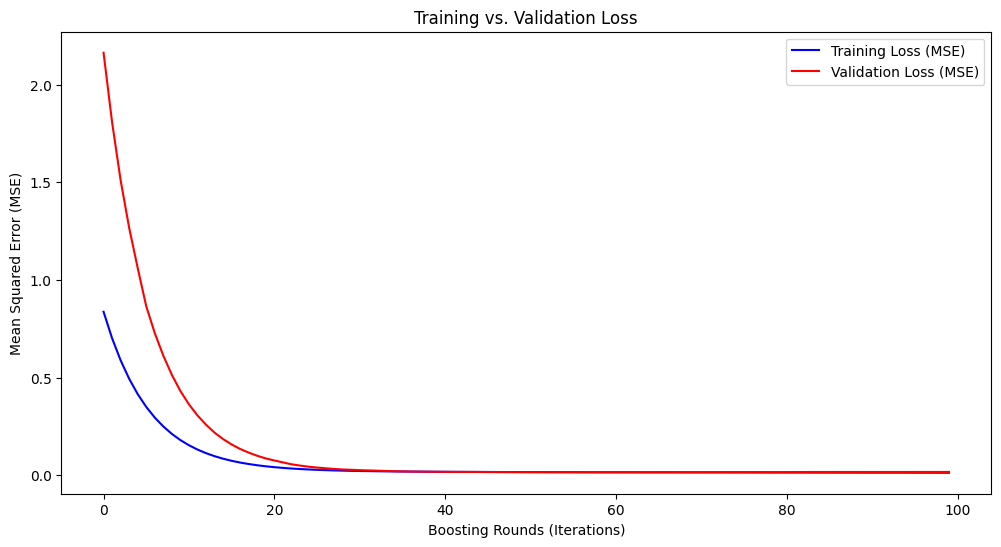

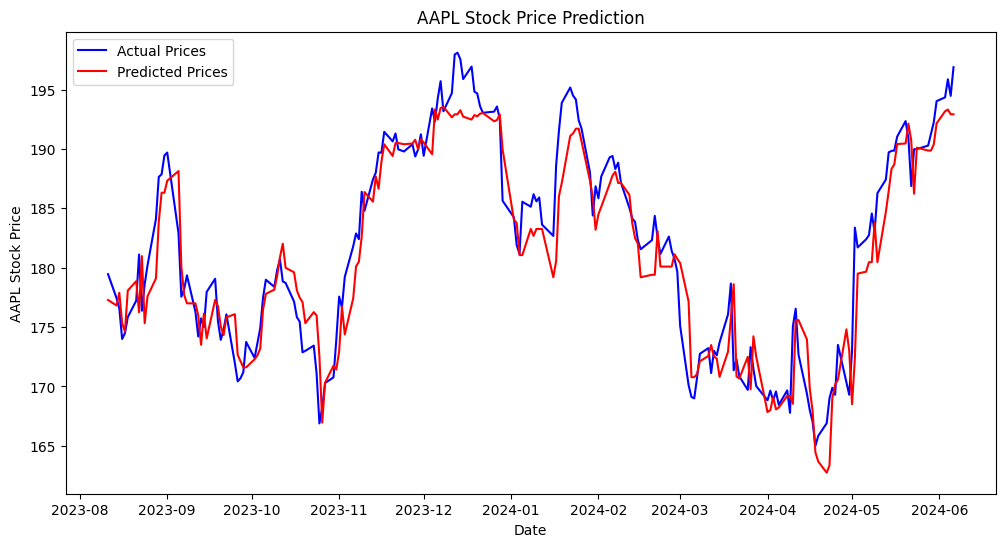

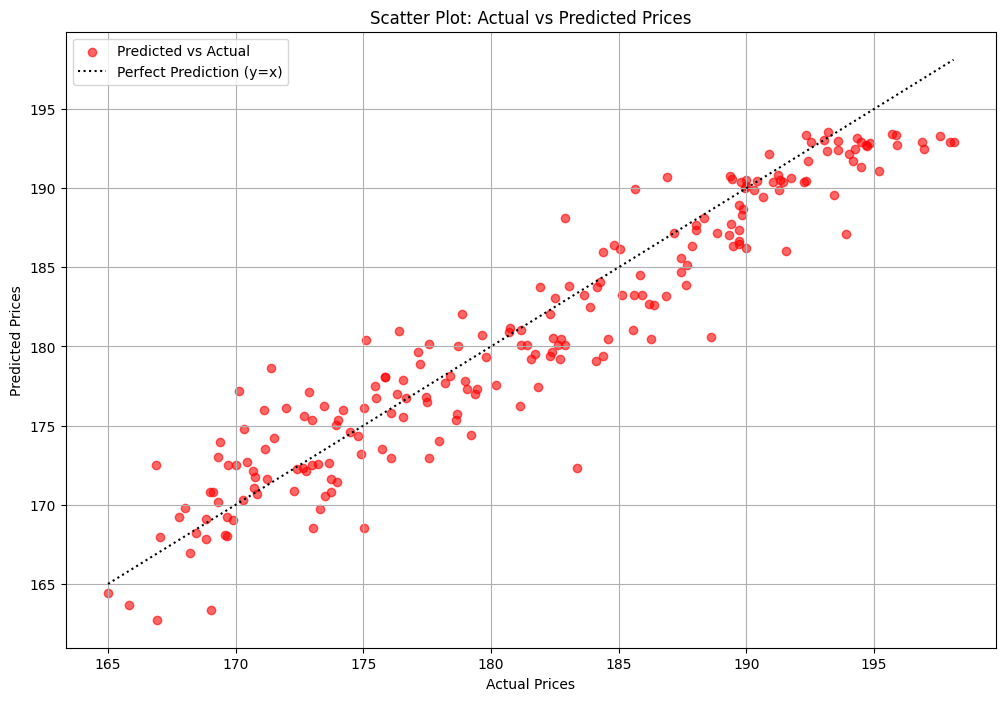

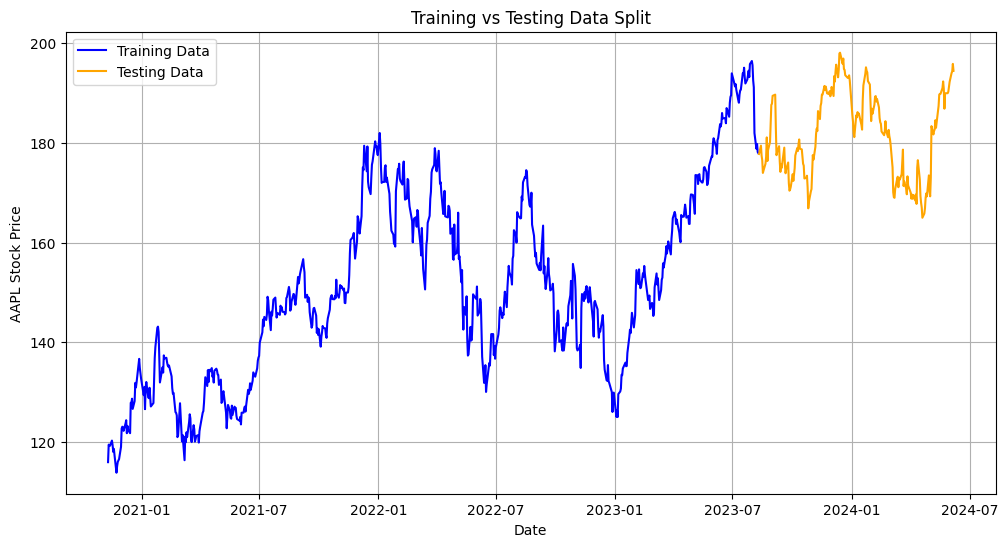

In [7]:
# Plot Training vs Validation Loss
epochs = len(evals_result['train']['rmse'])
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), np.square(evals_result['train']['rmse']), label='Training Loss (MSE)', color='blue')
plt.plot(range(epochs), np.square(evals_result['eval']['rmse']), label='Validation Loss (MSE)', color='red')
plt.xlabel("Boosting Rounds (Iterations)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

# Plot Actual vs Predicted Prices
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, np.expm1(y_test), label="Actual Prices", color='blue')
plt.plot(test_data.index, np.expm1(y_pred_test), label="Predicted Prices", color='red')
plt.xlabel("Date")
plt.ylabel("AAPL Stock Price")
plt.title("AAPL Stock Price Prediction")
plt.legend()
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(12, 8))
plt.scatter(np.expm1(y_test), np.expm1(y_pred_test), color='red', alpha=0.6, label='Predicted vs Actual')
plt.plot([min(np.expm1(y_test)), max(np.expm1(y_test))], [min(np.expm1(y_test)), max(np.expm1(y_test))], color='black', linestyle='dotted', label='Perfect Prediction (y=x)')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Scatter Plot: Actual vs Predicted Prices")
plt.legend()
plt.grid()
plt.show()

# Plot Training vs Testing Split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Close'], label="Training Data", color='blue')
plt.plot(test_data.index, test_data['Close'], label="Testing Data", color='orange')
plt.xlabel("Date")
plt.ylabel("AAPL Stock Price")
plt.title("Training vs Testing Data Split")
plt.legend()
plt.grid()
plt.show()

